<a href="https://colab.research.google.com/github/ClovisDyArx/SSL/blob/main/TP_Explicabilit%C3%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TP : Explicabilité des modèles de deep learning pour les images avec LIME et SHAP**

## **Objectif**
Ce TP vise à explorer comment interpréter les prédictions d’un modèle de deep learning appliqué aux images à l’aide de **LIME** et **SHAP**. Ces outils permettent d’identifier les parties de l’image qui influencent le plus les décisions du modèle, contribuant ainsi à rendre les modèles plus transparents et compréhensibles.

---

## **Contexte**
Les modèles de deep learning, bien qu’efficaces, sont souvent considérés comme des boîtes noires. Comprendre pourquoi un modèle fait une certaine prédiction est essentiel pour :  
1. Identifier les biais potentiels dans le modèle.  
2. Valider la fiabilité des prédictions dans des applications sensibles.  
3. Construire la confiance des utilisateurs finaux.

Dans ce TP, nous allons :  
1. Charger un modèle de classification d’images pré-entraîné avec PyTorch.  
2. Utiliser ce modèle pour prédire les classes d’images fournies.  
3. Appliquer **LIME** et **SHAP** pour expliquer ces prédictions.  
4. Comparer les visualisations générées par ces deux outils et analyser les résultats.

---

## **Plan du TP**

### **Étape 1 : Préparation de l’environnement**
1. Installer les bibliothèques nécessaires pour PyTorch, LIME, et SHAP.  
2. Télécharger ou préparer un ensemble d’images pour les tests (votre dataset préféré, des images issues d’ImageNet, etc.).

---

### **Étape 2 : Charger un modèle pré-entraîné**
1. Nous allons utiliser un modèle pré-entraîné disponible dans PyTorch, comme ResNet18 ou VGG16, avec des poids pré-entraînés sur ImageNet.  
2. Le modèle sera utilisé pour effectuer des prédictions sur les images, après les avoir redimensionnées et normalisées en fonction des besoins du modèle.  
3. Pour chaque image, nous afficherons les classes prédites avec leurs scores de confiance.

---

### **Étape 3 : Explicabilité avec LIME**
1. **Présentation de LIME :**  
   LIME fonctionne en créant des perturbations localisées sur une image (par exemple, en masquant des zones spécifiques) pour mesurer l’impact de chaque zone sur la prédiction.  
2. **Étapes :**  
   - Segmenter l’image en pixels ou en superpixels.  
   - Identifier les zones les plus influentes pour une prédiction donnée.  
   - Générer une heatmap mettant en évidence les zones importantes pour la classe prédite.  
3. Nous analyserons les résultats pour comprendre quelles parties de l’image influencent le plus la prédiction.

---

### **Étape 4 : Explicabilité avec SHAP**
1. **Présentation de SHAP :**  
   SHAP utilise la théorie des jeux pour attribuer une importance à chaque pixel ou groupe de pixels, en mesurant leur contribution à la prédiction.  
2. **Étapes :**  
   - Fournir les images prétraitées au modèle pour calculer les valeurs SHAP.  
   - Générer une visualisation qui montre les contributions positives et négatives des pixels ou des superpixels pour la prédiction.  
3. Nous interpréterons les visualisations en observant les zones qui favorisent ou défavorisent la classe prédite.

---

### **Étape 5 : Comparaison et analyse des résultats**
1. **Comparaison des visualisations :**  
   - Identifier les différences et similitudes entre les résultats de LIME et SHAP.  
   - Analyser les zones mises en évidence par chaque méthode.  
2. **Discussion :**  
   - Quels sont les points forts et limites de chaque méthode ?  
   - Les deux approches donnent-elles des explications cohérentes ?  
   - Quels défis rencontrons-nous en utilisant ces outils avec des modèles de grande taille ou des images complexes ?

---

## **Livrables attendus**
1. Les heatmaps générées par LIME et SHAP pour au moins deux images.  
2. Une analyse comparative des résultats obtenus avec LIME et SHAP.  
---

# **Préparation de l'environnement**

In [48]:
!pip install lime

In [121]:
import torch
import lime
import shap

from lime import lime_image
from skimage.segmentation import mark_boundaries

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [76]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


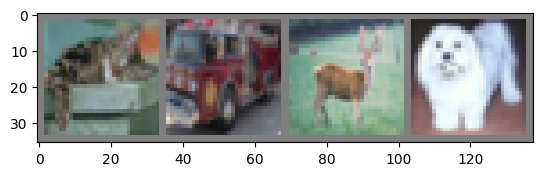

cat  		truck		deer 		dog  


In [80]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('\t\t'.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# **Création d'un petit CNN**

In [124]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


cnn = CNN()

In [116]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
epochs = 10

In [ ]:
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

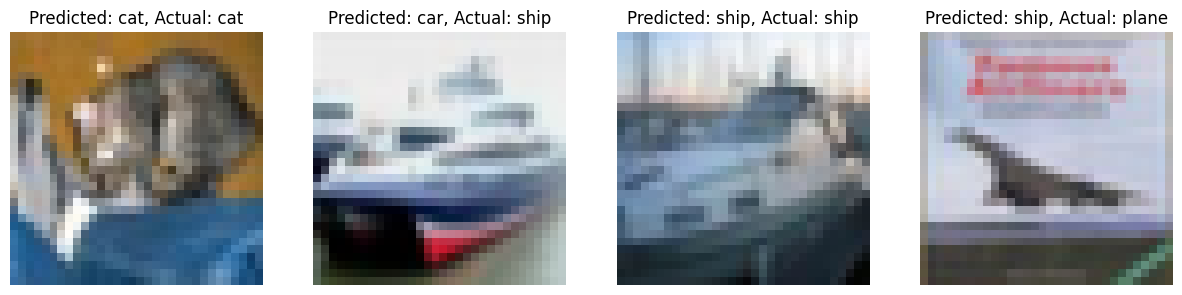

In [101]:
dataiter = iter(testloader)
images, labels = next(dataiter)

outputs = cnn(images)
_, predicted = torch.max(outputs, 1)

fig, axes = plt.subplots(1, len(images), figsize=(15, 5))

for i, ax in enumerate(axes):
    img = images[i] / 2 + 0.5
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(f"Predicted: {classes[predicted[i]]}, Actual: {classes[labels[i]]}")
    ax.axis('off')

plt.show()

In [102]:
PATH = './cifar_net.pth'
torch.save(cnn.state_dict(), PATH)

In [103]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cnn(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 59 %


# **Explicabilité avec LIME**

In [126]:
cnn.eval()

image_index = 0
image = images[image_index].cpu().numpy()
label = labels[image_index]

In [130]:
def predict_fn(images):
    images = images.transpose((0, 3, 1, 2))
    images = torch.from_numpy(images).float()
    images = images.to(device)
    with torch.no_grad():
        outputs = cnn(images)
    probas = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
    return probas

In [131]:
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    image.transpose(1, 2, 0),
    predict_fn,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

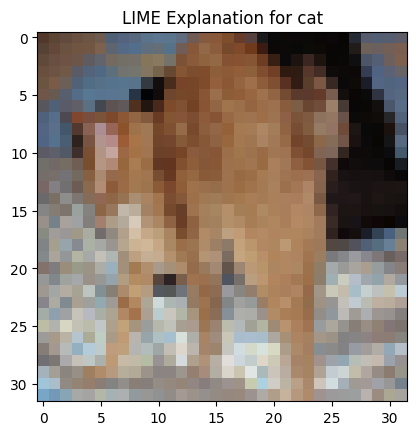

In [132]:
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title(f"LIME Explanation for {classes[explanation.top_labels[0]]}")
plt.show()

In [141]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vgg16
import matplotlib.pyplot as plt
import numpy as np
from lime import lime_image
import shap

from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries


In [137]:
# Transformation pour normaliser les images CIFAR-10
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionner les images pour VGG16
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Charger les ensembles de test
batch_size = 8
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# Classes de CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [138]:
# Charger le modèle VGG16 pré-entraîné sur ImageNet
model = vgg16(pretrained=True)

# Adapter pour CIFAR-10
model.classifier[6] = nn.Linear(4096, len(classes))

# Définir un optimiseur et une fonction de perte
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Passer le modèle sur GPU si disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [139]:
num_epochs = 2
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zéro gradient
        optimizer.zero_grad()

        # Forward + backward + optim
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  # Affichage toutes les 100 itérations
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Entraînement terminé')

KeyboardInterrupt: 

  0%|          | 0/1000 [00:00<?, ?it/s]

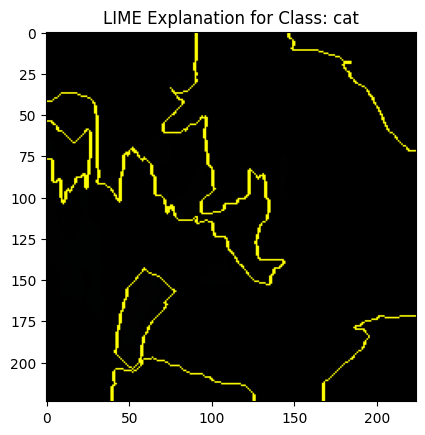

In [142]:
# Choisir une image de test
model.eval()
dataiter = iter(testloader)
images, labels = next(dataiter)
image = images[0].to(device)  # Une seule image pour l'explication

# Fonction prédictive pour LIME
def predict_fn(images):
    images = torch.tensor(images.transpose(0, 3, 1, 2)).to(device, dtype=torch.float32)
    outputs = model(images)
    return outputs.detach().cpu().numpy()

# Créer un explainer LIME
explainer = LimeImageExplainer()
explanation = explainer.explain_instance(
    images[0].cpu().numpy().transpose(1, 2, 0),
    predict_fn,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f'LIME Explanation for Class: {classes[labels[0]]}')
plt.show()

In [148]:
# Créer un explainer SHAP
background = images[:batch_size].to(device)
explainer = shap.DeepExplainer(model, background)

# Calculer les valeurs SHAP pour une image
# Wrap the model prediction in a function that takes a tensor with requires_grad=True
def model_predict(x):
    with torch.no_grad():  # Disable gradient calculation for the prediction
        return model(x).cpu().numpy()

# Convert the input image to a tensor with requires_grad=True
image_with_grad = image.unsqueeze(0).clone().requires_grad_(True).to(device)

# Calculate SHAP values
# Instead of passing ranked_outputs as an argument to shap_values directly
# we can calculate the shap values and get the top predictions with this
shap_values = explainer.shap_values(image_with_grad, model_predict)
shap_values = shap_values[np.argsort(model_predict(image_with_grad))[-5:][::-1]]


# Visualiser les résultats
shap.image_plot(shap_values, images[0].cpu().numpy().transpose(1, 2, 0))

TypeError: slice indices must be integers or None or have an __index__ method